# IMAGE SEGMENTATION OF THE CAMBRIDGE-DRIVING CAMVID DATASET WITH U-NET

Presented in this notebook is the implementation of the convolutional neural network model U-Net presented in a 2015 [paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). The implementation follows a similar approach to what given by the DeepLearning.AI team in the [Deep Learning specialization](https://www.coursera.org/specializations/deep-learning) and is schematized in  Fig. 1. 

The model consists essentially in a contracting path (encoder) and an exanding path (decoder):
- The encoder learns the features of the input, at the expenses of the spatial resolution.
- The decoder restore the lost spatial resolution and initial channels.
Further details are given in Section [4](#4).

The network is trained on the CamVid dataset (Cambridge-driving Labeled Video Database) downloaded from [Kaggle](https://www.kaggle.com/datasets/carlolepelaars/camvid), and is implemented using tensorflow on the GPU of the M1 chip of a 2022 Macbook Pro. 

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Fig. 1 </u></b>: U-Net Architecture Schematic<br> </center></caption>

## Table of contents

- [1 - LOAD PACKAGES](#1)
- [2 - ENVIRONMENT CHECK](#2)
- [3 - DATA PREPROCESSING AND PREPARATION](#3)
    - [3.1 - RGB TO SINGLE CHANNEL MASK](#3.1)
    - [3.2 - LOAD AND VISUALIZE THE DATASET](#3.2)
    - [3.3 - PREPROCESS THE DATASET AND VISUALIZE IT](#3.3)
- [4 - U-NET](#4)
    - [4.1 - ENCODER IMPLEMENTATION](#4.1)
    - [4.2 - DECODER IMPLEMENTATION](#4.2)
    - [4.3 - COMPLETE NETWORK](#4.3)
- [5 - LOSS FUNCTION AND MODEL SUMMARY](#5)
- [6 - TRAIN THE MODEL](#6)
- [7 - U-NET PERFORMANCE AND PREDICTIONS](#7)

<a name='1'></a>
## 1 - LOAD PACKAGES

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from PIL import Image

# import utils downloaded from DeepLearning.AI
from test_utils import summary, comparator 

<a name='2'></a>
## 2 - ENVIRONMENT CHECK

Note that this operation will print some warnings since we're using the GPU accelerator of the M1 pro chip with apple-metal. The GPU is used, simply ignore the warning.

In [2]:
from platform import python_version
print("Python version: ", python_version())
print("Tensorflow version: ", tf.__version__)

Python version:  3.8.13
Tensorflow version:  2.10.0


In [3]:
x_test = tf.random.uniform([3, 3])

print("GPU available: ", tf.test.is_gpu_available())
print("Test tensor on GPU No.0: ", x_test.device.endswith('GPU:0'))

Metal device set to: Apple M1 Pro
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  True
Test tensor on GPU No.0:  True


2022-11-17 15:09:06.695656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 15:09:06.695758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-17 15:09:06.717049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 15:09:06.717071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<a name='3'></a>
## 3 - DATA PREPROCESSING AND PREPARATION

<a name='3.1'></a>
### 3.1 - RGB TO SINGLE CHANNEL MASK

The masks included in the dataset are coded as rgb images.  In the following cell we take the `.csv` file listing the classes and their corresponding `rgb` encoding, we use it to convert the masks into single-channel png files, and we finally save the result in a directory. We need to pay attention to the fact that Mac OS will save an extra file in the directory, that will have to be accounted for.

In [4]:
# define path of image, rgb mask and single channel mask directories
img_path = './CamVid/train/'
rgb_msk_path = './CamVid/train_labels_rgb/'
sc_msk_path = './CamVid/train_labels_sc/'
label_path = './CamVid/class_dict.csv'

# process image path
img_list = os.listdir(img_path)
img_list = [img_path + i for i in img_list]
img_list.sort()

# process rgb mask path
rgb_msk_list = os.listdir(rgb_msk_path)
rgb_msk_list = [rgb_msk_path + i for i in rgb_msk_list]
rgb_msk_list.sort()

# process single channel mask path
sc_msk_list = os.listdir(sc_msk_path)
sc_msk_list = [sc_msk_path + i for i in sc_msk_list]
sc_msk_list.sort()
sc_msk_list = sc_msk_list[1:]

msk_labels = pd.read_csv(label_path)
label_array = msk_labels.values

def rgb_to_singlechannel_mask(rgb_msk, label_array):
    
    singlechannel_msk = np.zeros((rgb_msk.shape[0], rgb_msk.shape[1]), dtype=np.uint8)
    
    for i in range(len(label_array)):
        
        indices = np.where(np.all(rgb_msk == label_array[i,1:4], axis = -1))
        
        if len(indices[0]) and len(indices[1]) > 1: 
            # one could use i*8 to give more contrast with 32 classes: 256/32 = 8
            singlechannel_msk[indices[0], indices[1]] = i
            
    return singlechannel_msk

In [5]:
# here with os.listdir(sc_msk_array) we have the list of names to save

get_rgb_msk_name = os.listdir(rgb_msk_path)
get_rgb_msk_name.sort()

if len(sc_msk_list) < len(rgb_msk_list):
    
    for i in range(len(rgb_msk_list)):

        rgb_msk = imageio.imread(rgb_msk_list[i])
        sc_msk_array = rgb_to_singlechannel_mask(rgb_msk, label_array)

        sc_msk = Image.fromarray(sc_msk_array)
        #sc_msk.save(sc_msk_path+'msk_{}.png'.format(i+1), 'png')
        sc_msk.save(sc_msk_path+get_rgb_msk_name[i], 'png')
        save_info = "Processed and saved {} mask out of {}"
        print(save_info.format(i+1, len(msk_list)))

<a name='3.2'></a>
### 3.2 - LOAD AND VISUALIZE THE DATASET

In this section we are going to define the path where the data is stored and create a list of the images and their corresponding mask. Next we set a variable `ind`to plot an image and its mask from the list; in case `ind >= len(list)` the cell shows the last image of the list.

/var/folders/b0/4ps11syj1jz_5clmvns4yxvh0000gn/T/ipykernel_84550/4195593566.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_check = imageio.imread(img_list[ind])
/var/folders/b0/4ps11syj1jz_5clmvns4yxvh0000gn/T/ipykernel_84550/4195593566.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb_msk_check = imageio.imread(rgb_msk_list[ind])
/var/folders/b0/4ps11syj1jz_5clmvns4yxvh0000gn/T/ipykernel_84550/4195593566.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this war

(-0.5, 959.5, 719.5, -0.5)

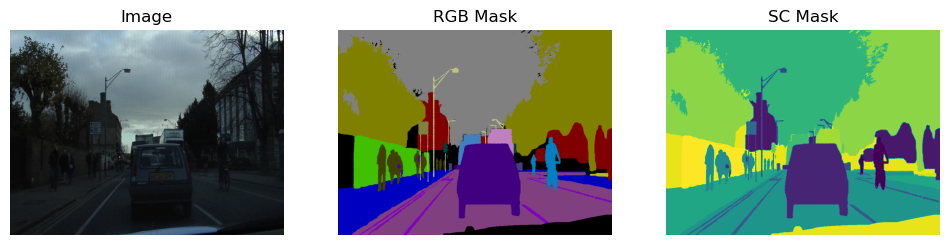

In [6]:
# check image and mask. If ind is larger than No of images it selects the last one
ind = min(7, len(img_list)-1)

img_check = imageio.imread(img_list[ind])
rgb_msk_check = imageio.imread(rgb_msk_list[ind])
sc_msk_check = imageio.imread(sc_msk_list[ind])

fig, axs = plt.subplots(1, 3, figsize=(12, 9))

axs[0].imshow(img_check)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(rgb_msk_check)
axs[1].set_title('RGB Mask')
axs[1].axis('off')

axs[2].imshow(sc_msk_check)
axs[2].set_title('SC Mask')
axs[2].axis('off')

<a name='3.3'></a>
### 3.3 - PREPROCESS DATASET AND VISUALIZE IT

In this subsection we create a dataset from what we loaded using the tensorflow function `tf.data.Dataset.from_tensor_slices`. Next, we normalize the data using tensorflow function `tf.image.convert_image_dtype` which sets the value between 0 and 1.

In [7]:
# create constant tensor from a the list of images and masks (tensor-like object)
img_name = tf.constant(img_list)
sc_msk_name = tf.constant(sc_msk_list)

# generate dataset of tensors split into images and their masks
dataset = tf.data.Dataset.from_tensor_slices((img_name, sc_msk_name))

# define helper function to normalize the pixel value and set it between 0 and 1
def normalize_from_path(img_path, msk_path):
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_png(msk, channels = 1)
    #msk = tf.image.convert_image_dtype(msk, tf.float32)
    # the following line assumes masks defined only on one of the RGBA channels (other channels=0)
    #msk = tf.math.reduce_max(msk, axis=-1, keepdims=True)
    
    return img, msk

# define helper to resize the image and mask size
def resize(img, msk):
    
    input_img = tf.image.resize(img, (2*96, 2*128), method = 'nearest')
    input_msk = tf.image.resize(msk, (2*96, 2*128), method = 'nearest')
    
    return input_img, input_msk

# generate the mapping
img_dataset = dataset.map(normalize_from_path)
processed_img_dataset = img_dataset.map(resize)

Visualize original and processed image:

2022-11-17 15:09:07.055006: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


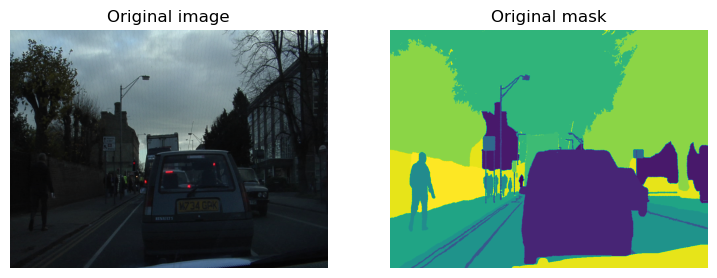

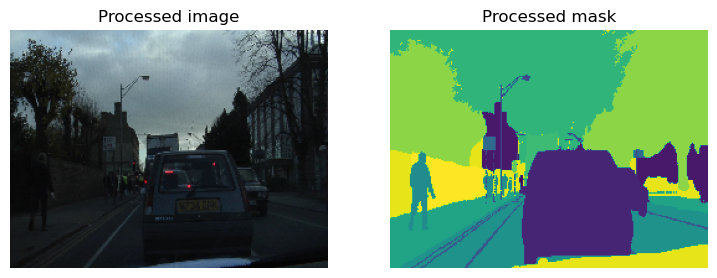

In [8]:
def display_img(list_of_img, plt_title):
    
    plt.figure(figsize=(9, 7))
    
    for i in range(len(list_of_img)):
        plt.subplot(1, len(list_of_img), i+1)
        plt.title(plt_title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(list_of_img[i]))
        plt.axis('off')
    plt.show()

for image, mask in img_dataset.take(1):
    display_img([image, mask], ['Original image', 'Original mask'])
for image, mask in processed_img_dataset.take(1):
    display_img([image, mask], ['Processed image', 'Processed mask'])

<a name='4'></a>
## 4 - U-NET

Detailed in the following is the implementation of U-Net schematized in Fig. 1. The model consists essentially in a contracting path (encoder) and an exanding path (decoder):
- The encoder is characterized by repeated 3x3 same convolutions followed by 2x2 max pools that reduce the dimension of the input. The deeper the encoder goes, the richer the featured that it learns, at the expenses of the spatial resolution. For this reason, skip connection are implemented for every level to save the spatial information for the decoder. During the contracting path the depth of the data increases at every level.
- The decoder is characterized by repeated 3x3 same convolutions followed by 2x2 transpose convolutions to expand the input. The transpose convolution output is concatenated with the skip connections of the corresponding layer from the contracting path, restoring the lost spatial information. Along the expanding path the depth of the data decreases at every level, until the original 3 RGB channels of the input are restored.

The implementation given schematized in Fig. 1 and given in the following follows a similar approach to what given by the DeepLearning.AI team in the [Deep Learning specialization](https://www.coursera.org/specializations/deep-learning).

<a name='4.1'></a>
### 4.1 - ENCODER IMPLEMENTATION

The encoder (contracting path) starts at the input of the network and ends at the deepest layer, right before the first transpose convolution. It is composed of repeated `encoder_block` consisting in 2 following 3x3 same convolutions followed by a 2x2 max pooling operation, that halves height and width of the data. To some layers, a dropout operation will be applied. The function returns two tensors: `next_layer_input` (the input to be fed to the next layer), `skip_connection` (the tensor to be fed to the decoder).

- `input_tensor` is the tensor fed to the layer
- `n_filters` is the number of filters used at each layer
- `kernel_size = 3` harcoded as we're implementing 3x3 filter convolutions
- `activation = 'relu'` as we adopt a linear unit activation
- `padding = 'same'` for a same convolution operation
- `kernel_initializer = 'he_normal'`: read more ['here'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal)
- if `dropout_prob > 0` a drop-out will be applied after the convolutions
- if `max_pool = True` a max pool will be applied

In [9]:
def encoder_block(input_tensor, n_filters=32, dropout_prob = 0, max_pool = True):
    
    # first 3x3 same convolution
    X = Conv2D(n_filters, 
               kernel_size = 3, 
               activation = 'relu', 
               padding = 'same', 
               kernel_initializer = 'he_normal')(input_tensor)
    
    # second 3x3 same convolution
    X = Conv2D(n_filters,
               kernel_size = 3,
               activation = 'relu',
               padding = 'same',
               kernel_initializer = 'he_normal')(X)
    
    # apply dropout layer
    if dropout_prob > 0:
        X = Dropout(dropout_prob)(X)
    
    # apply max pool operation
    if max_pool:
        next_layer_input = MaxPooling2D(pool_size = (2,2))(X)
    else: next_layer_input = X
    
    # define skip connection for the sake of clarity (one could use X directly)
    skip_connection = X
    
    return next_layer_input, skip_connection

<a name='4.2'></a>
### 4.2 - DECODER IMPLEMENTATION

The decoder (expanding path) starts with the first transpose convolution and operated until the output of the network. It is composed of repeated `decoder_block`s consisting in a transpose convolution applied to the ouput of the previous layer, whose result is then concatenated with the `skip_connection` from the corresponding layer of the encoder: this operation restores the spatial resolution by incresing height and width of the tensor progressively. The tensor resulting from the concatenation is fed to 2 following 3x3 same convolutions. The function returns a tensor: `upsampling_output`.

- `input_tensor` is the tensor fed to the layer to which we apply the `Conv2DTranspose`
- `n_filters` is the number of filters used at each layer
- The result is then concatenated with the `skip_connection` tensor from the contracting path
- `kernel_size = 3` harcoded as we're implementing 3x3 filter convolutions
- `activation = 'relu'` as we adopt a linear unit activation
- `padding = 'same'` for a same convolution operation
- `kernel_initializer = 'he_normal'`

In [10]:
def decoder_block(input_tensor, skip_connection, n_filters=32):
    
    # transpose 2D convolution to upsample height and width of the input
    up = Conv2DTranspose(n_filters,
                         kernel_size = 3,
                         strides = 2,
                         padding = 'same')(input_tensor)
    
    # concatenate the upsampled tensor and the skip connection from the encoder
    concat = concatenate([up, skip_connection], axis = 3)
    
    # first 3x3 same convolution
    upsampling_output = Conv2D(n_filters,
              kernel_size = 3,
              activation = 'relu',
              padding = 'same',
              kernel_initializer = 'he_normal')(concat)
    
    # second 3x3 same convolution
    upsampling_output = Conv2D(n_filters,
              kernel_size = 3,
              activation = 'relu',
              padding = 'same',
              kernel_initializer = 'he_normal')(upsampling_output)
    
    return upsampling_output

<a name='4.3'></a>
### 4.3 - COMPLETE NETWORK

In the following we will implement the entire architecture of the U-Net model, chaining encoder and decoder. Since each pixel of the input image will be assigned to a different class, we need to define a total of 32 output classes. The steps that the network takes are listed in the folloing:
- define the shape of the input tensor fed to the U-Net.
- Along the contracting path, apply `encoder_block` for a total of 5 times
- Start with `n_filters = 8` and double it at each layer
- `dropout_prob > 0` at the 4th and 5th layer
- `max_pool = False` at the 5th layer (bottleneck of the network)
- Use the bottleneck output and apply `decoder_block` for a total of 4 times
- Concatenate the proper `skip_connection` at each layer with the result of the transpose convolution
- Half `n_filters` at each level
- Apply a 3x3 same convolution 
- Final 1x1 convolution with the correct number of output classes: `n_filters = 32`

In [11]:
def u_net_network(input_size = (96, 128, 3), n_filters = 32, n_classes = 32):
    
    # define input for the keras model implementation
    input_tensor = Input(input_size)
    
    # define the chain of convolutions and max pooling of the contracting path
    next_layer, skip_connection0 = encoder_block(input_tensor, n_filters)
    next_layer, skip_connection1 = encoder_block(next_layer, 2 * n_filters)
    next_layer, skip_connection2 = encoder_block(next_layer, 4 * n_filters)
    next_layer, skip_connection3 = encoder_block(next_layer, 8 * n_filters, dropout_prob = 0.3)
    next_layer, _ = encoder_block(next_layer, 16 * n_filters, dropout_prob = 0.3, max_pool = False)
    
    # define the chain of transpose and standard convolutions of the expanding path
    next_layer = decoder_block(next_layer, skip_connection3, 8 * n_filters)
    next_layer = decoder_block(next_layer, skip_connection2, 4 * n_filters)
    next_layer = decoder_block(next_layer, skip_connection1, 2 * n_filters)
    next_layer = decoder_block(next_layer, skip_connection0, n_filters)
    
    # define the 3x3 same convolution with the original spatial resolution
    next_layer = Conv2D(n_filters,
                       kernel_size = 3,
                       activation = 'relu',
                       padding = 'same',
                       kernel_initializer = 'he_normal')(next_layer)
    
    # define the 1x1 same convolution with the output number of classes
    output = Conv2D(n_classes, 
                   kernel_size = 1,
                   padding = 'same')(next_layer)
    
    u_net_model = tf.keras.Model(inputs = input_tensor, outputs = output)
    
    return u_net_model

<a name = '5'></a>
## 5 - LOSS FUNCTION AND MODEL SUMMARY

Since the model chooses to assign each pixel to a classes base on a probability distribution, we choose categorical crossentropy as loss function. This choice tends to be more efficient than other with many classes.






In [12]:
# set the model dimensions
img_height = 2*96
img_width = 2*128
rgb_channels = 3

u_net = u_net_network((img_height, img_width, rgb_channels))
u_net.summary()
u_net.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])                        

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 192, 256, 32  1056        ['conv2d_18[0][0]']              
                                )                                                                 
                                                                                                  
Total params: 8,640,768
Trainable params: 8,640,768
Non-trainable params: 0
__________________________________________________________________________________________________


<a name = '6'></a>
## 6 - TRAIN THE MODEL

Here we train the model on the dataset.

In [13]:
EPOCHS = 100
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_img_dataset.batch(BATCH_SIZE)
train_dataset = processed_img_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_img_dataset.element_spec)
model_history = u_net.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/100


2022-11-17 15:09:08.074140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 12s 830ms/step - loss: 3.3613 - accuracy: 0.0765
Epoch 2/100
12/12 [==============================] - 11s 880ms/step - loss: 2.6274 - accuracy: 0.2724
Epoch 3/100
12/12 [==============================] - 10s 849ms/step - loss: 2.0953 - accuracy: 0.4821
Epoch 4/100
12/12 [==============================] - 11s 879ms/step - loss: 1.6910 - accuracy: 0.5943
Epoch 5/100
12/12 [==============================] - 10s 874ms/step - loss: 1.4861 - accuracy: 0.6196
Epoch 6/100
12/12 [==============================] - 10s 871ms/step - loss: 1.3305 - accuracy: 0.6334
Epoch 7/100
12/12 [==============================] - 11s 895ms/step - loss: 1.2465 - accuracy: 0.6395
Epoch 8/100
12/12 [==============================] - 10s 873ms/step - loss: 1.1919 - accuracy: 0.6493
Epoch 9/100
12/12 [==============================] - 10s 855ms/step - loss: 1.1367 - accuracy: 0.6585
Epoch 10/100
12/12 [==============================] - 10s 870ms/step - loss: 1.0793 - accuracy

12/12 [==============================] - 10s 862ms/step - loss: 0.2325 - accuracy: 0.9274
Epoch 81/100
12/12 [==============================] - 10s 860ms/step - loss: 0.2261 - accuracy: 0.9294
Epoch 82/100
12/12 [==============================] - 10s 862ms/step - loss: 0.2225 - accuracy: 0.9305
Epoch 83/100
12/12 [==============================] - 10s 809ms/step - loss: 0.2142 - accuracy: 0.9331
Epoch 84/100
12/12 [==============================] - 10s 806ms/step - loss: 0.2083 - accuracy: 0.9346
Epoch 85/100
12/12 [==============================] - 10s 842ms/step - loss: 0.2044 - accuracy: 0.9358
Epoch 86/100
12/12 [==============================] - 10s 865ms/step - loss: 0.2038 - accuracy: 0.9358
Epoch 87/100
12/12 [==============================] - 10s 864ms/step - loss: 0.1978 - accuracy: 0.9376
Epoch 88/100
12/12 [==============================] - 10s 807ms/step - loss: 0.1960 - accuracy: 0.9383
Epoch 89/100
12/12 [==============================] - 10s 872ms/step - loss: 0.1917 - 

<a name = '7'></a>
## 7 - U-NET PERFORMANCE AND PREDICTIONS

In this section we plot the behaviour of the accuracy per epoch. Then, we compare the mask predicted by the implementation of U-Net and compare it to the actual mask.

(0.0, 1.0)

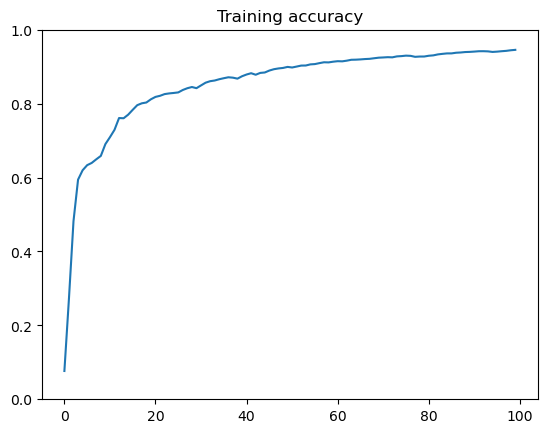

In [22]:
# plot the accuracy of the model
plt.plot(model_history.history["accuracy"])
plt.title("Training accuracy")
plt.ylim(0, 1)

1/1 [==============================] - 0s 15ms/step


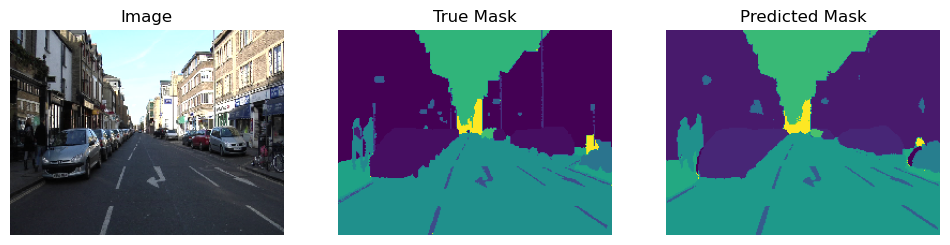

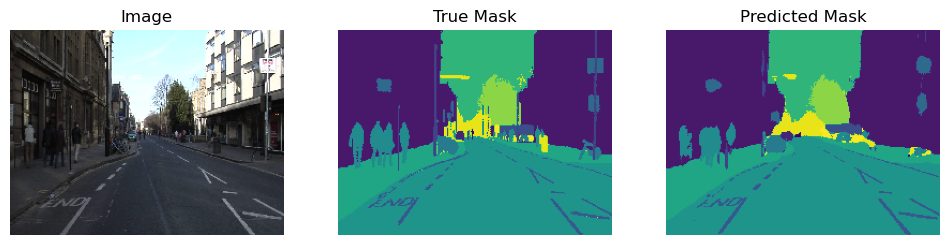

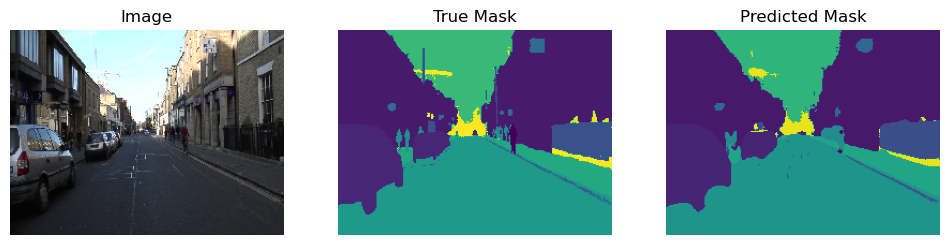

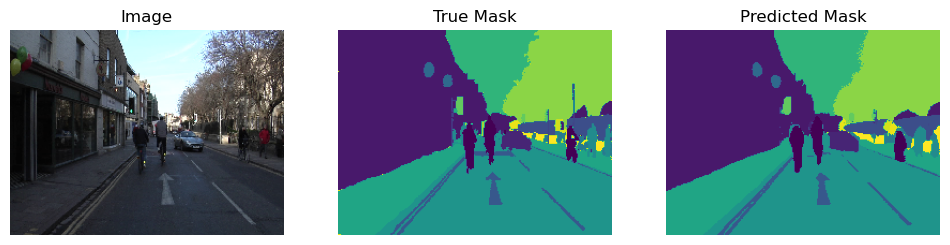

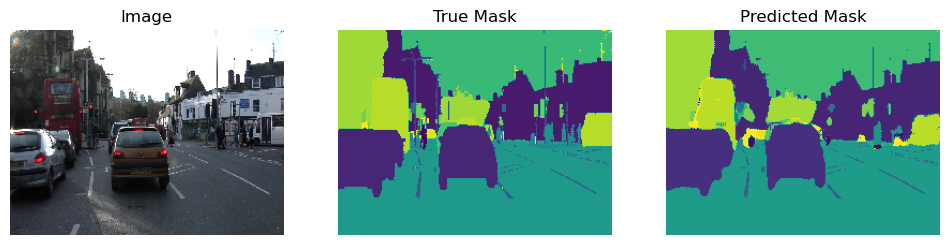

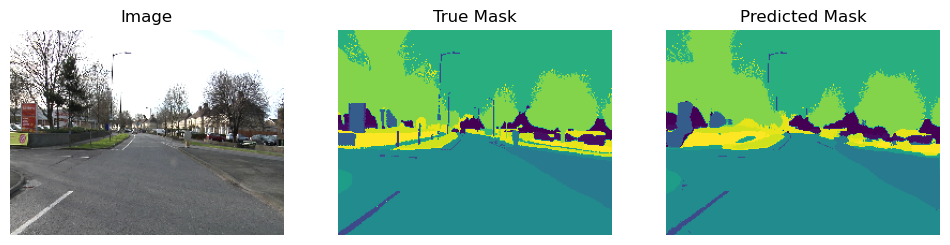

In [16]:
# choose the number of image, mask and prediction to compare
number = 6

for img, msk in train_dataset.take(number):
    
    predicted_msk = u_net.predict(img)
    predicted_msk = tf.argmax(predicted_msk, axis = -1)
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 9))

    axs[0].imshow(img[0])
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(msk[0])
    axs[1].set_title('True Mask')
    axs[1].axis('off')

    axs[2].imshow(predicted_msk[0])
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')